# Data prep

## Import packages

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load data

In [2]:
DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513


## Drop not important features

In [3]:
print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009


## Feature engineering 

In [4]:
sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,STAR,-0.000009,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,STAR,-0.000055,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,GALAXY,0.123111,1.297604,-0.590023,0.140338
3,183.870529,0.049911,STAR,-0.000111,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,STAR,0.000590,-0.849271,1.287505,-0.397689


## Split into train/test sets

In [5]:
X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Scale the data

In [6]:
robust_scaler = RobustScaler()
std_scaler = StandardScaler()
maxabs_scaler = MaxAbsScaler()

X_train_std_scaled = std_scaler.fit_transform(X_train.astype(np.float64))
X_test_std_scaled = std_scaler.fit_transform(X_test.astype(np.float64))

X_train_rob_scaled = robust_scaler.fit_transform(X_train.astype(np.float64))
X_test_rob_scaled = robust_scaler.fit_transform(X_test.astype(np.float64))

X_train_maxabs_scaled = maxabs_scaler.fit_transform(X_train.astype(np.float64))
X_test_maxabs_scaled = maxabs_scaler.fit_transform(X_test.astype(np.float64))

data_sets = []

std_scaled_set = DataSet("Standard Scaled", X_train_std_scaled, y_train, X_test_std_scaled, y_test)
robust_scaled_set = DataSet("Robust Scaled", X_train_rob_scaled, y_train, X_test_rob_scaled, y_test)
max_abs_set = DataSet("MaxABS Scaled", X_train_maxabs_scaled, y_train, X_test_maxabs_scaled, y_test)

data_sets.append(std_scaled_set)
data_sets.append(robust_scaled_set)
data_sets.append(max_abs_set)

# Classification

## Prepare result sets

In [7]:
result_sets = []

# Classfiers
knn_clf = KNeighborsClassifier()
svm_clf = SVC(gamma="auto", random_state=42)
lsvm_clf = LinearSVC(C=10, loss="hinge", random_state=42)
nusvm_clf = NuSVC(nu=0.05, gamma=0.1)
rbf_svm_clf = SVC(kernel="rbf", gamma=0.1, C=1000)
poly_svm_clf = SVC(kernel="poly", gamma="scale", degree=3, coef0=100, C=5)
tree_clf = DecisionTreeClassifier(random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
log_clf = LogisticRegression(
    solver="liblinear", random_state=42, multi_class='auto')
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.05, 
                                    max_features=2, max_depth = 4, random_state = 42)
# Xgboost parameters
xgb_params = {'learning_rate': 0.05,
              'max_depth': 4,
              'subsample': 0.9,
              'colsample_bytree': 0.9,
              'objective': 'binary:logistic',
              'silent': 1,
              'n_estimators': 100,
              'gamma': 1,
              'min_child_weight': 4,
              # ENABLE GPU COMPUTING BY UNCOMMENTING BELOW
              # 'gpu_id': 0,
              # 'tree_method': 'gpu_hist'
              }
xgb_clf = XGBClassifier(**xgb_params, seed=42)
bag_df_clf = BaggingClassifier(
    DecisionTreeClassifier(
        splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=500,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
sgd_clf = SGDClassifier(max_iter=500, tol=-np.infty, random_state=42)
mlp_clf = MLPClassifier(random_state=42, max_iter=2000)
xtree_clf = ExtraTreesClassifier(n_estimators=10, random_state=42)
pa_clf = PassiveAggressiveClassifier(max_iter=5000, random_state=0, tol=1e-3)
r_clf = RidgeClassifier()
nb_clf = GaussianNB()
mnb_clf = MultinomialNB()
lda_clf = LinearDiscriminantAnalysis()
qda_clf = QuadraticDiscriminantAnalysis()
v_clf = VotingClassifier(estimators=[
    ("SVC", svm_clf),
    ("NuSVC", nusvm_clf),
    ("RbfSVC", rbf_svm_clf),
    ("PolySVC", poly_svm_clf),
    ("Tree", tree_clf),
    ("RF", rnd_clf),
    ("XGB", xgb_clf),
    ("Bagging", bag_df_clf),
    ("MLP", mlp_clf),
    ("XTrees", xtree_clf),
    ("NaiveBayes", nb_clf),
    ("QDA", qda_clf),
], voting="hard", n_jobs=-1)

# CLF names
clf_names = ["KNN",
             "SVC",
             "LinearSVM",
             "NuSVC", 
             "RbfKernelSVM", 
             "PolyKernelSVM",
             "DecisionTreeClassifier",
             "RandomForestClassifier", 
             "LogisticRegression", 
             "GradientBoostingClassifier", 
             "XGBClassifier", 
             "BaggingClassifier",
             "AdaBoostClassifier",
             "SGDClassifier",
             "MLPClassifier", 
             "ExtraTreesClassifier",
             "PassiveAggressiveClassifier",
             "RidgeClassifier",
             "GaussianNB", 
             "MultinomialNB", 
             "LinearDiscriminantAnalysis",
             "QuadraticDiscriminantAnalysis",
             "VotingClassifier"]

clfs = [knn_clf,
        svm_clf,
        lsvm_clf,
        nusvm_clf,
        rbf_svm_clf, 
        poly_svm_clf,
        tree_clf, 
        rnd_clf, 
        log_clf, 
        gb_clf,
        xgb_clf, 
        bag_df_clf,
        ada_clf,
        sgd_clf,
        mlp_clf, 
        xtree_clf,
        pa_clf,
        r_clf,
        nb_clf,
        mnb_clf,
        lda_clf,
        qda_clf, 
        v_clf]

## Run

Data Set Type:  Standard Scaled
KNN
[0.90206529 0.88607595 0.908      0.8945964  0.89793195]
Accuracy: 0.898 (+/- 0.015)
KNN :
 [[1060    2  184]
 [  12  218   12]
 [ 155    4  853]]
              precision    recall  f1-score   support

      GALAXY       0.86      0.85      0.86      1246
         QSO       0.97      0.90      0.94       242
        STAR       0.81      0.84      0.83      1012

   micro avg       0.85      0.85      0.85      2500
   macro avg       0.88      0.86      0.87      2500
weighted avg       0.85      0.85      0.85      2500



SVC
[0.9586942  0.95003331 0.966      0.9646431  0.96197465]
Accuracy: 0.960 (+/- 0.011)
SVC :
 [[1106    3  137]
 [  16  224    2]
 [  24    1  987]]
              precision    recall  f1-score   support

      GALAXY       0.97      0.89      0.92      1246
         QSO       0.98      0.93      0.95       242
        STAR       0.88      0.98      0.92      1012

   micro avg       0.93      0.93      0.93      2500
   macro av

ExtraTreesClassifier
[0.98134577 0.97468354 0.984      0.98332221 0.98132088]
Accuracy: 0.981 (+/- 0.007)
ExtraTreesClassifier :
 [[1214    4   28]
 [  15  227    0]
 [  11    1 1000]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.98      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.97      0.99      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.98      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



PassiveAggressiveClassifier
[0.96602265 0.93137908 0.97133333 0.94596398 0.9593062 ]
Accuracy: 0.955 (+/- 0.029)
PassiveAggressiveClassifier :
 [[1151   25   70]
 [  34  208    0]
 [ 104    2  906]]
              precision    recall  f1-score   support

      GALAXY       0.89      0.92      0.91      1246
         QSO       0.89      0.86      0.87       242
        STAR       0.93      0.90      0.91      1012

   micro avg   

{'STAR': 0.9927071379999148, 'GALAXY': 0.9831819077827357, 'QSO': 0.9710725501248088}


LinearDiscriminantAnalysis
{'STAR': 0.9197758617025799, 'GALAXY': 0.9064041615786145, 'QSO': 0.8817885351623979}


QuadraticDiscriminantAnalysis
{'STAR': 0.9925490883590463, 'GALAXY': 0.9859908965467806, 'QSO': 0.9859050282192242}


VotingClassifier
{'STAR': 0.9966397849462366, 'GALAXY': 0.9895973334766947, 'QSO': 0.9743208719776884}


Data Set Type:  Robust Scaled
KNN
[0.96535643 0.9586942  0.96866667 0.96931288 0.96597732]
Accuracy: 0.966 (+/- 0.008)
KNN :
 [[1133    5  108]
 [  17  225    0]
 [  28    0  984]]
              precision    recall  f1-score   support

      GALAXY       0.96      0.91      0.93      1246
         QSO       0.98      0.93      0.95       242
        STAR       0.90      0.97      0.94      1012

   micro avg       0.94      0.94      0.94      2500
   macro avg       0.95      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



SVC
[0.980

MLPClassifier
[0.98800799 0.98267821 0.99133333 0.99199466 0.98999333]
Accuracy: 0.989 (+/- 0.007)
MLPClassifier :
 [[1221    3   22]
 [  10  232    0]
 [   0    0 1012]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1246
         QSO       0.99      0.96      0.97       242
        STAR       0.98      1.00      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



ExtraTreesClassifier
[0.98134577 0.97468354 0.984      0.98332221 0.98132088]
Accuracy: 0.981 (+/- 0.007)
ExtraTreesClassifier :
 [[1214    4   28]
 [  15  227    0]
 [  11    1 1000]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.98      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.97      0.99      0.98      1012

   micro avg       0.98      0.98      0.98

{'STAR': 0.9927071379999148, 'GALAXY': 0.9831819077827357, 'QSO': 0.9710725501248088}


LinearDiscriminantAnalysis
{'STAR': 0.9197758617025799, 'GALAXY': 0.9064041615786145, 'QSO': 0.8817885351623979}


QuadraticDiscriminantAnalysis
{'STAR': 0.9925490883590463, 'GALAXY': 0.9859908965467806, 'QSO': 0.9859050282192242}


VotingClassifier
{'STAR': 0.9964817353053678, 'GALAXY': 0.9892011694199749, 'QSO': 0.9722547562752087}


Data Set Type:  MaxABS Scaled
KNN
[0.88341106 0.86742172 0.89       0.87991995 0.8832555 ]
Accuracy: 0.881 (+/- 0.015)
KNN :
 [[1065    2  179]
 [  16  217    9]
 [ 146    0  866]]
              precision    recall  f1-score   support

      GALAXY       0.87      0.85      0.86      1246
         QSO       0.99      0.90      0.94       242
        STAR       0.82      0.86      0.84      1012

   micro avg       0.86      0.86      0.86      2500
   macro avg       0.89      0.87      0.88      2500
weighted avg       0.86      0.86      0.86      2500



SVC
[0.769

MLPClassifier
[0.98334444 0.97868088 0.98333333 0.98799199 0.98465644]
Accuracy: 0.984 (+/- 0.006)
MLPClassifier :
 [[1191    3   52]
 [  15  227    0]
 [   0    0 1012]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.96      0.97      1246
         QSO       0.99      0.94      0.96       242
        STAR       0.95      1.00      0.97      1012

   micro avg       0.97      0.97      0.97      2500
   macro avg       0.98      0.96      0.97      2500
weighted avg       0.97      0.97      0.97      2500



ExtraTreesClassifier
[0.98134577 0.97468354 0.984      0.98332221 0.98132088]
Accuracy: 0.981 (+/- 0.007)
ExtraTreesClassifier :
 [[1214    4   28]
 [  15  227    0]
 [  11    1 1000]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.98      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.97      0.99      0.98      1012

   micro avg       0.98      0.98      0.98

{'STAR': 0.9925490883590463, 'GALAXY': 0.9859908965467806, 'QSO': 0.9859050282192242}


VotingClassifier
{'STAR': 0.9968177568107441, 'GALAXY': 0.989602453529124, 'QSO': 0.9722547562752087}




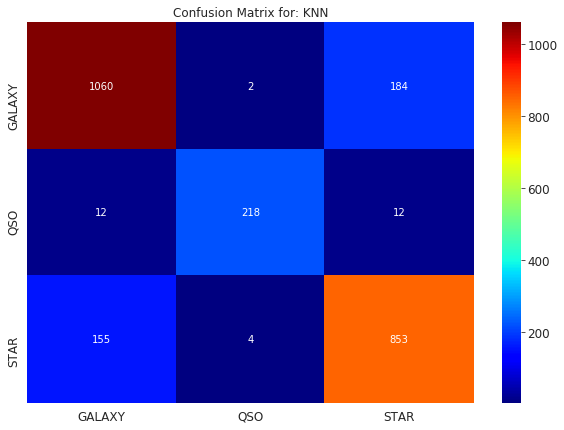

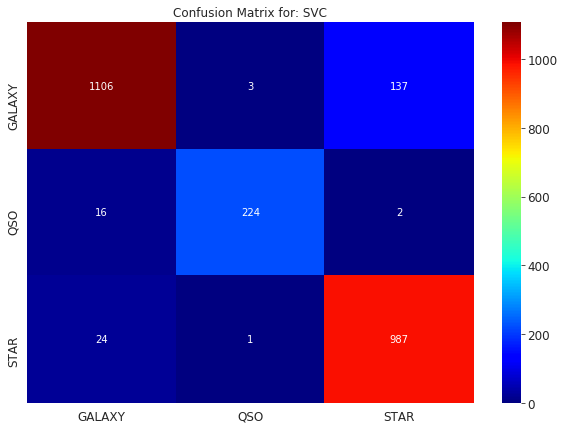

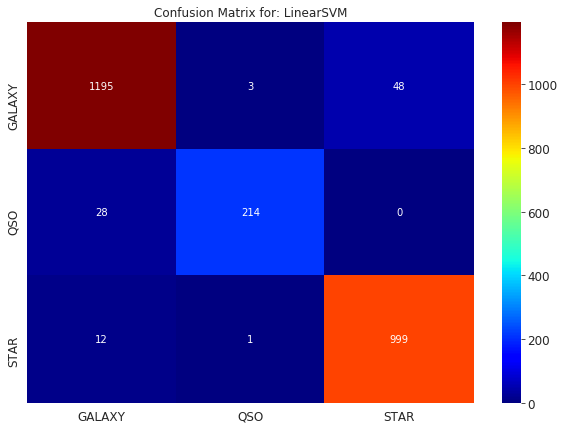

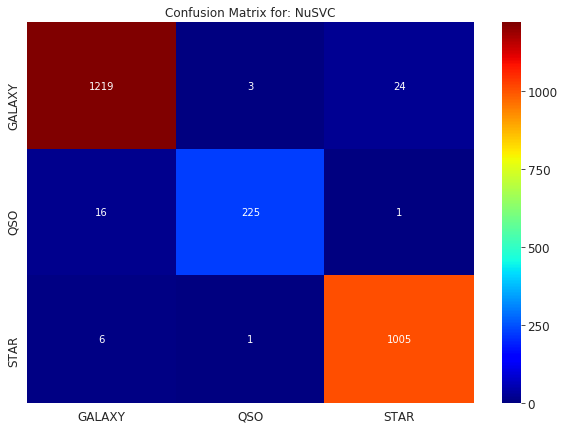

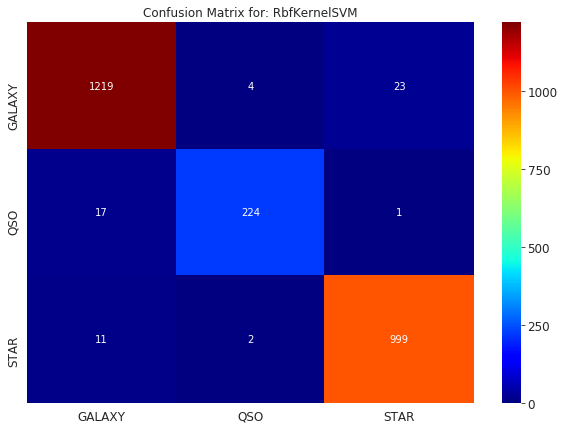

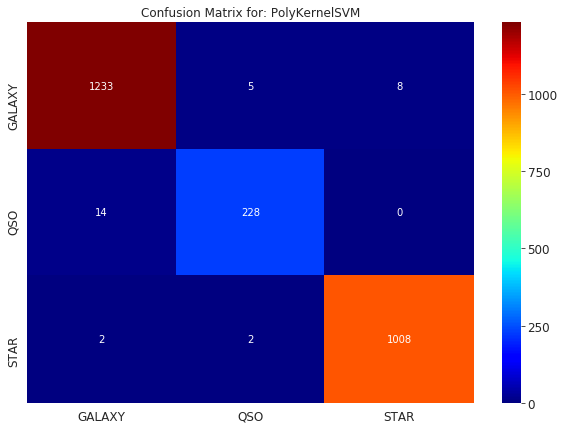

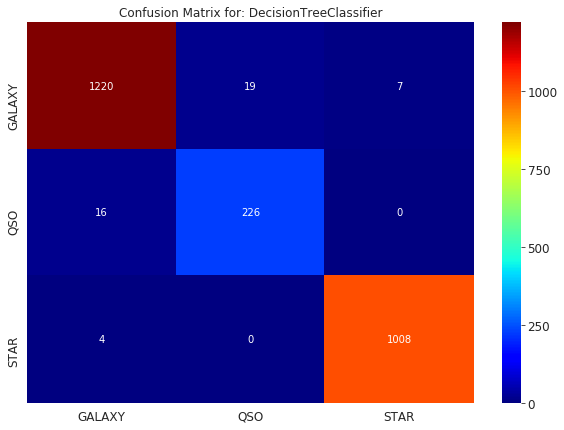

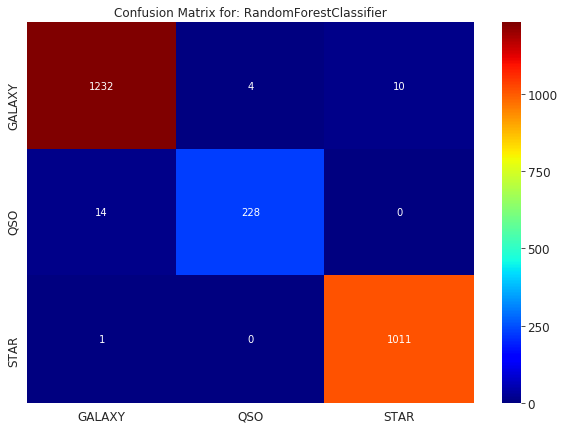

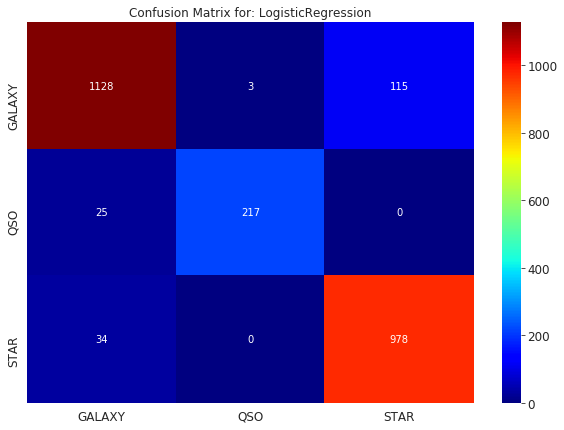

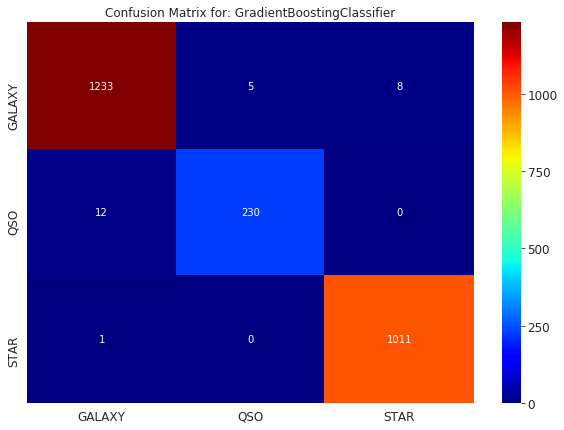

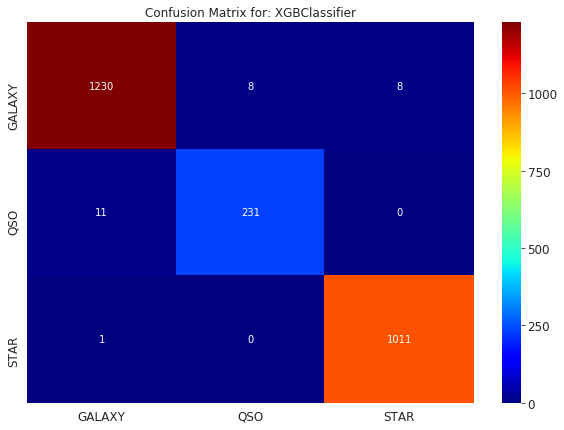

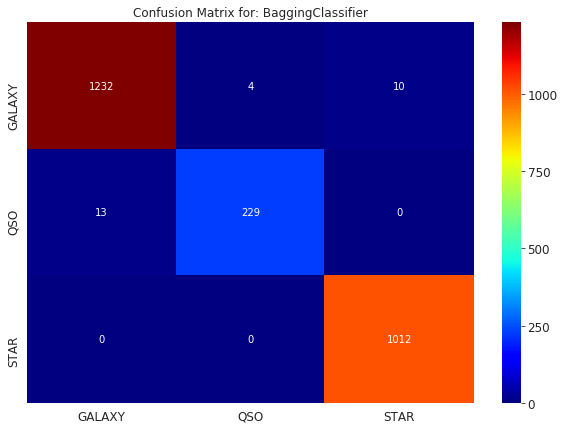

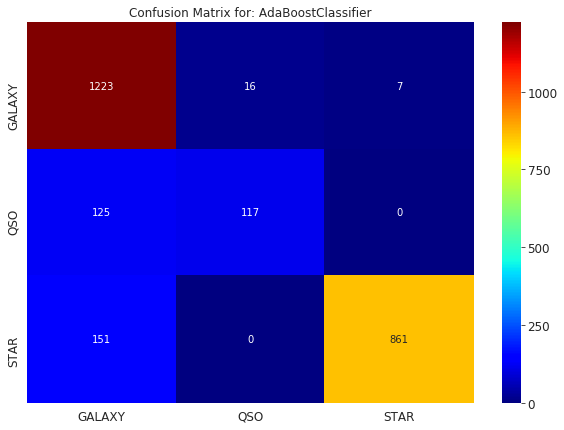

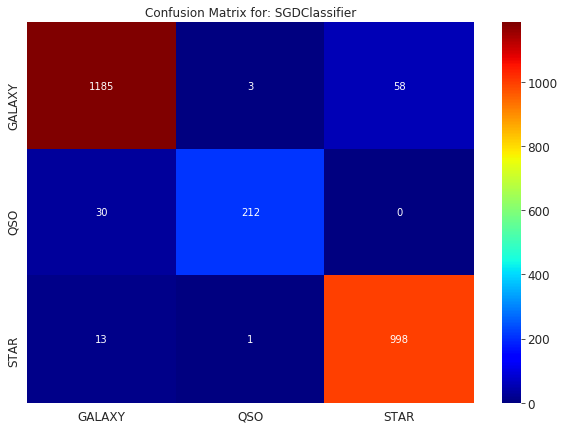

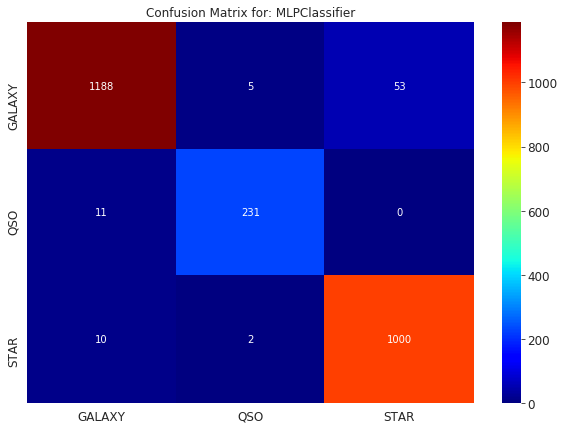

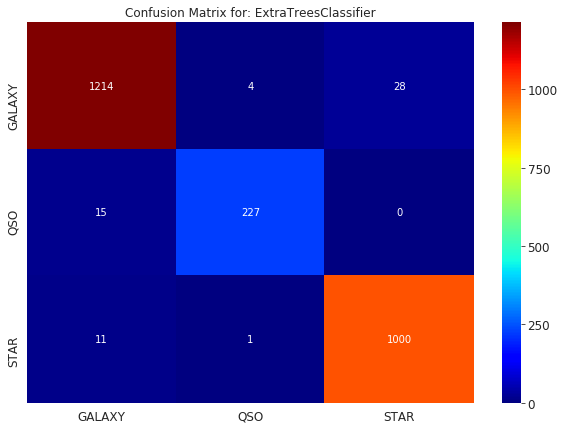

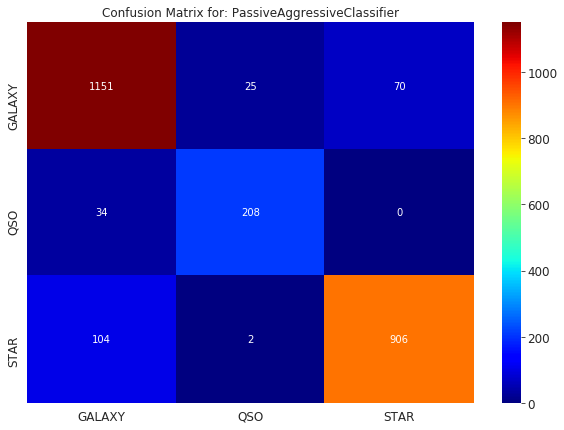

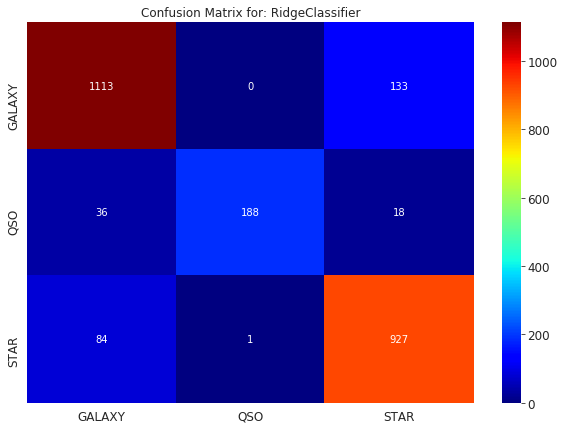

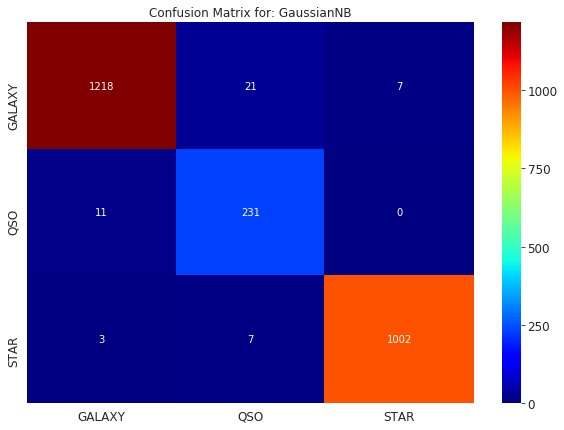

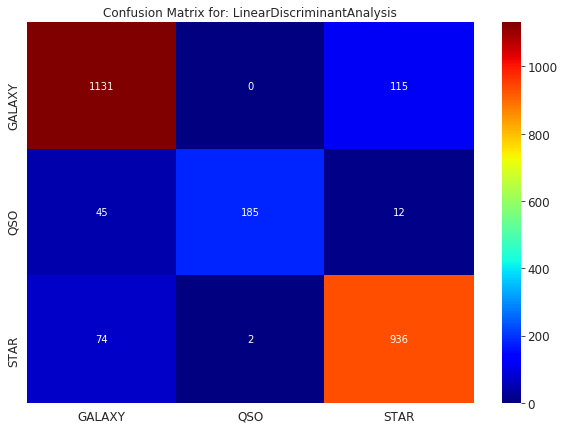

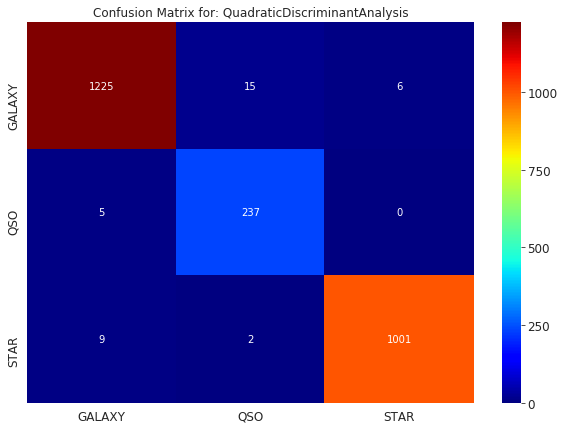

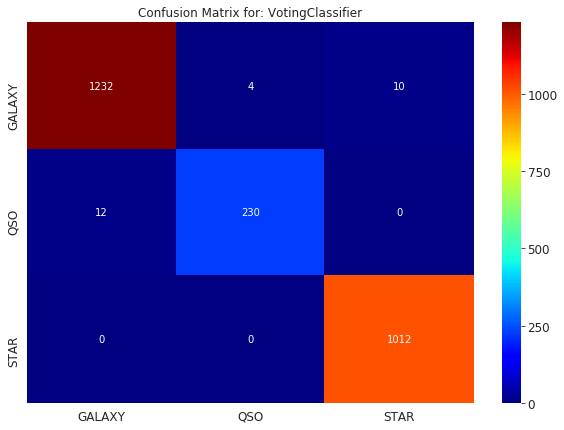

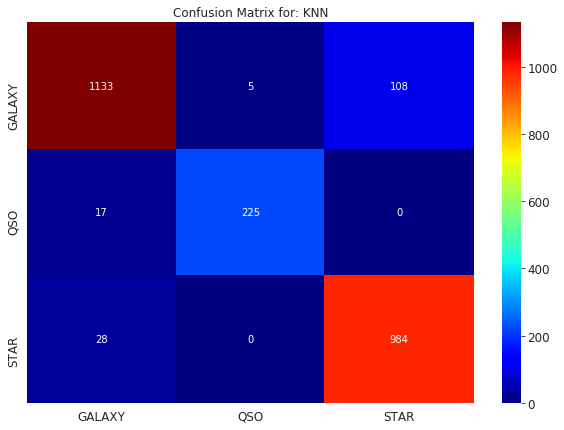

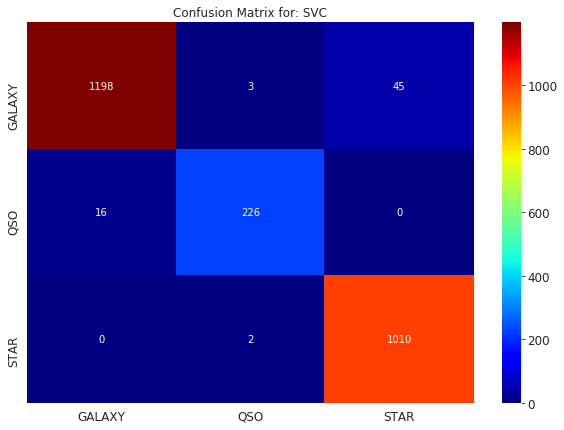

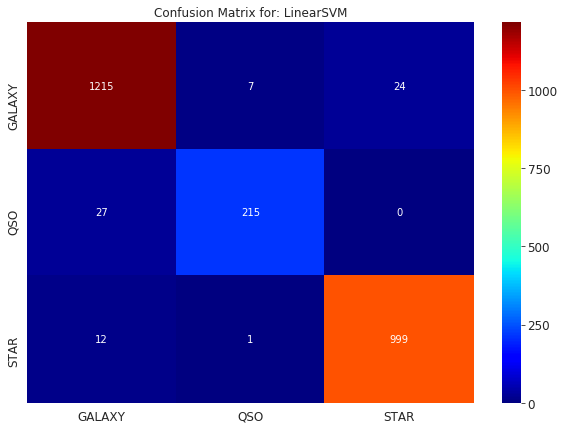

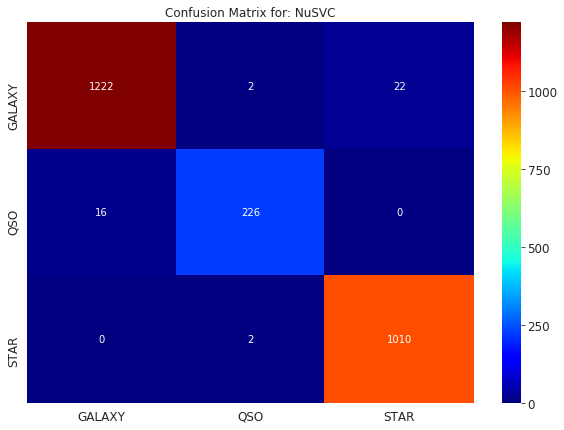

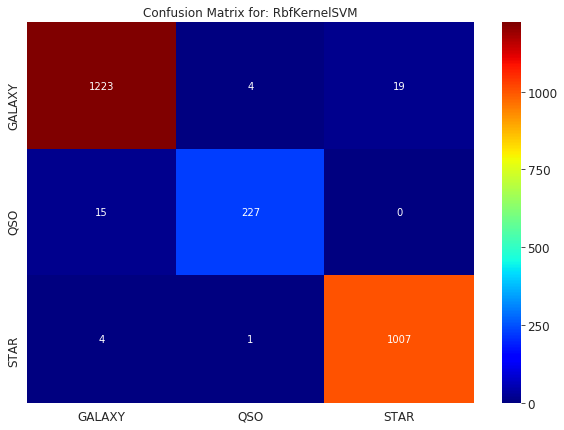

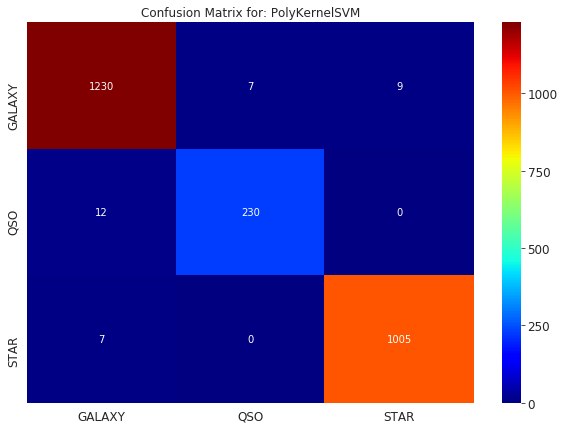

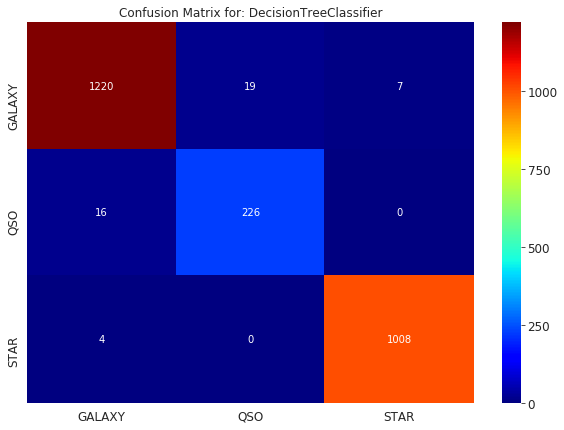

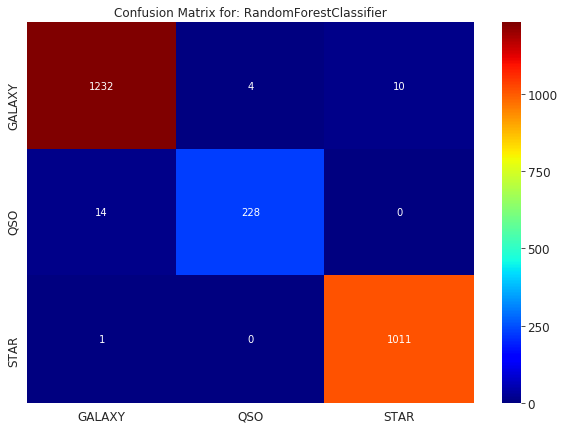

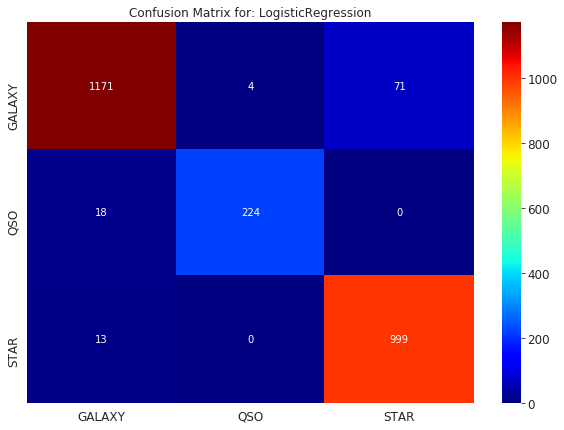

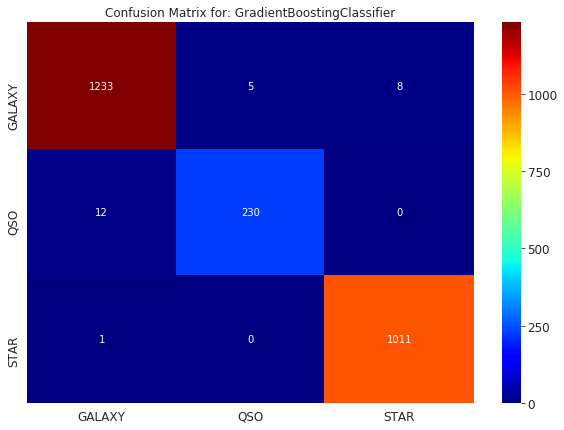

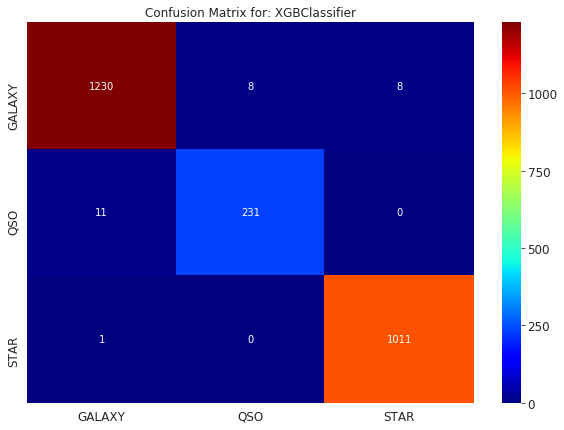

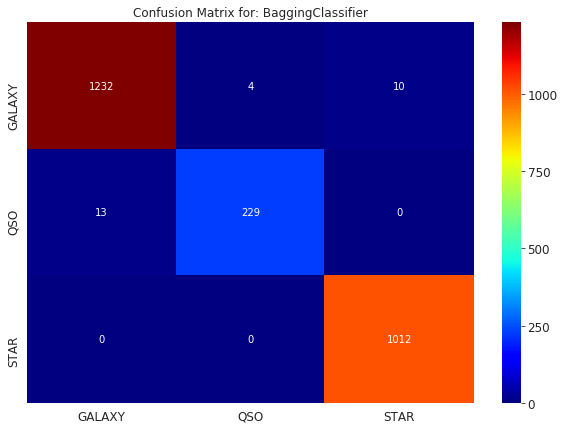

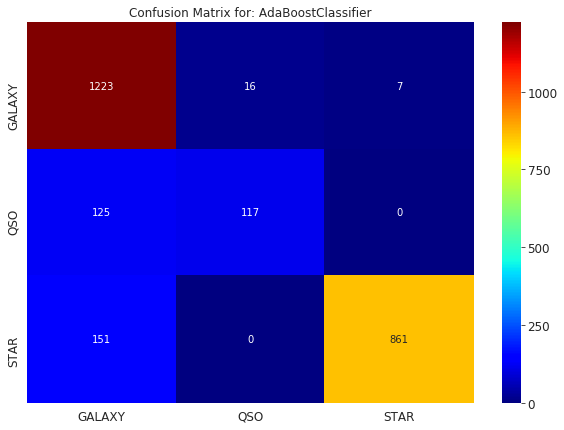

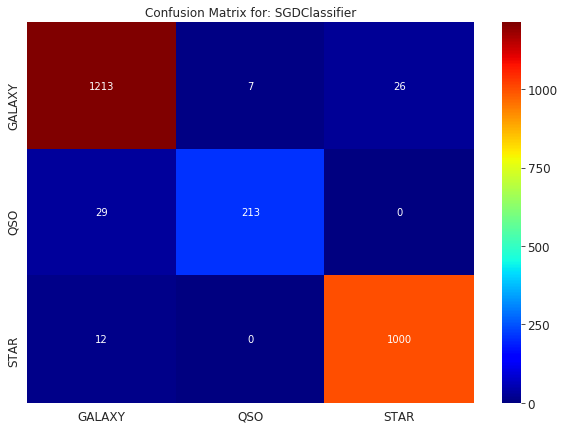

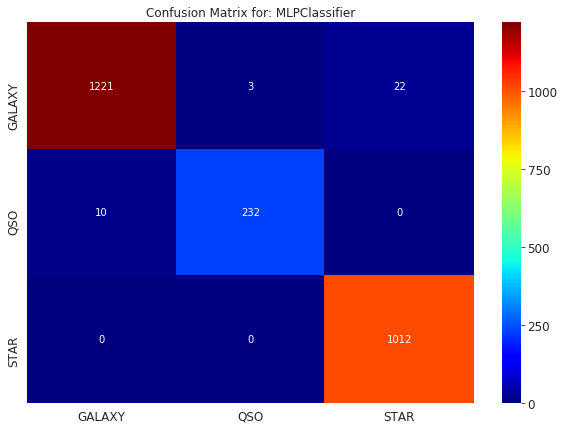

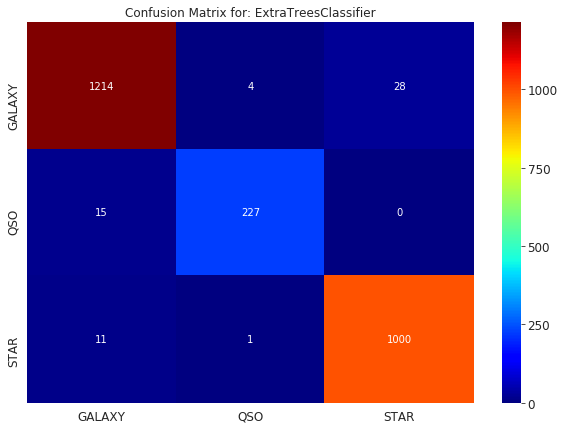

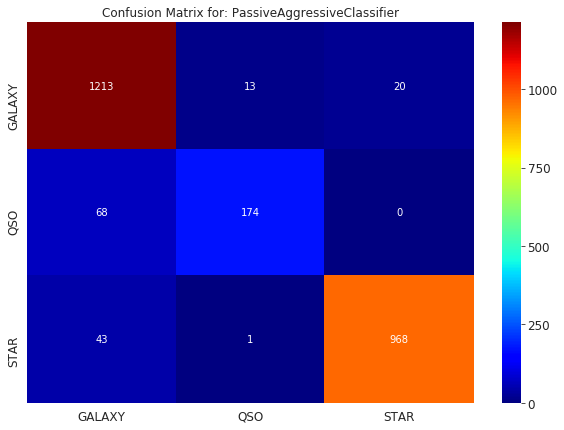

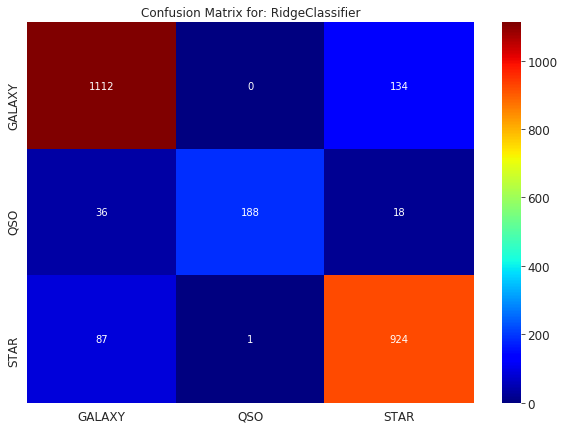

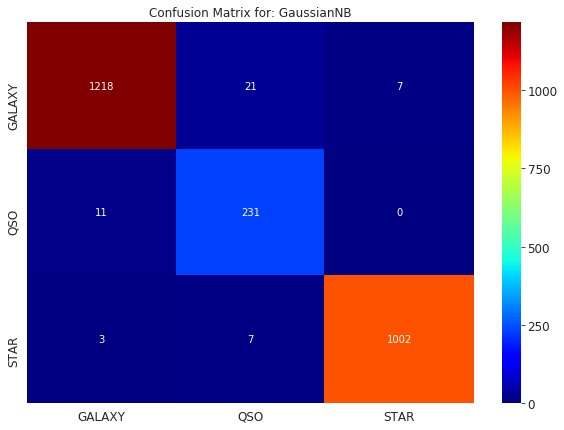

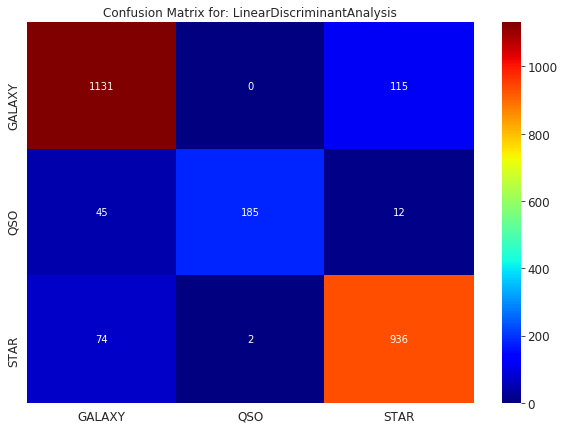

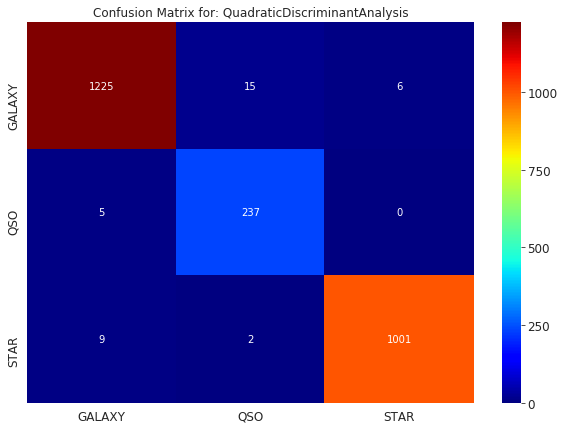

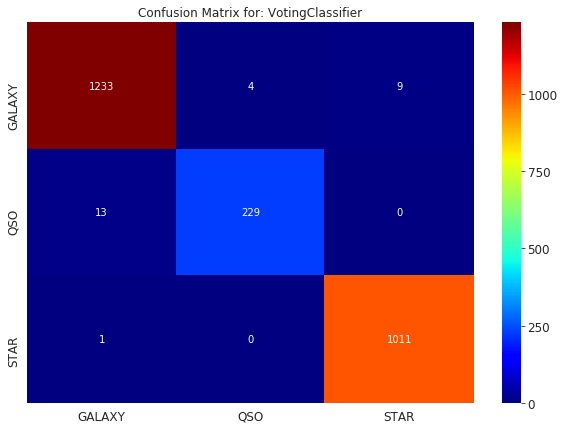

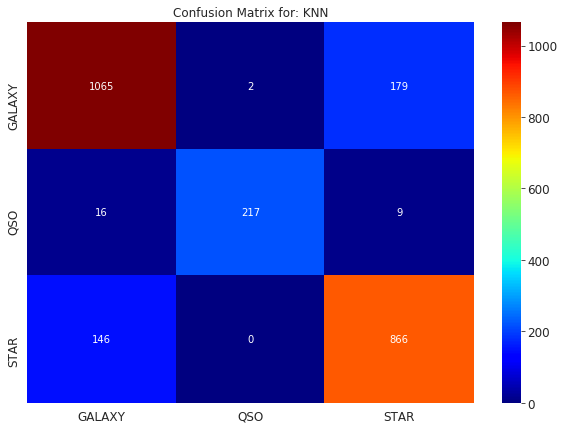

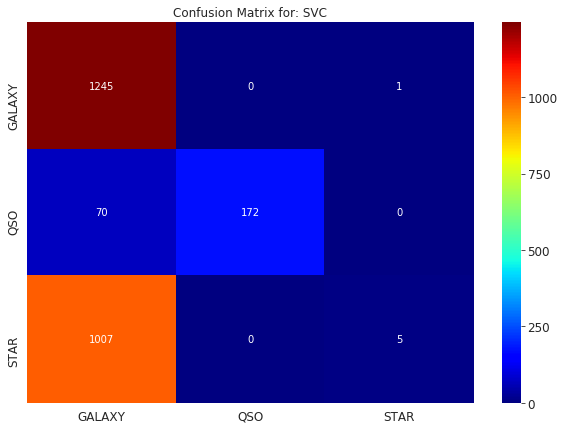

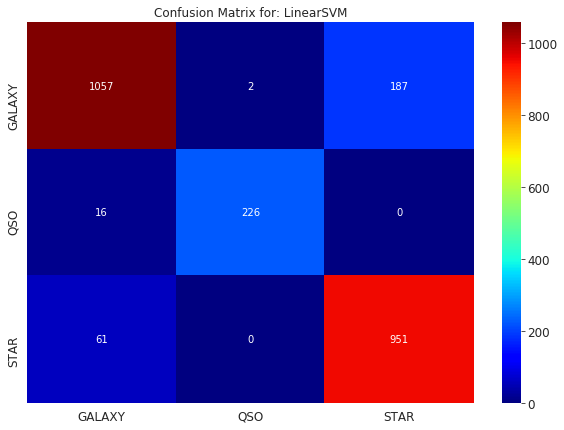

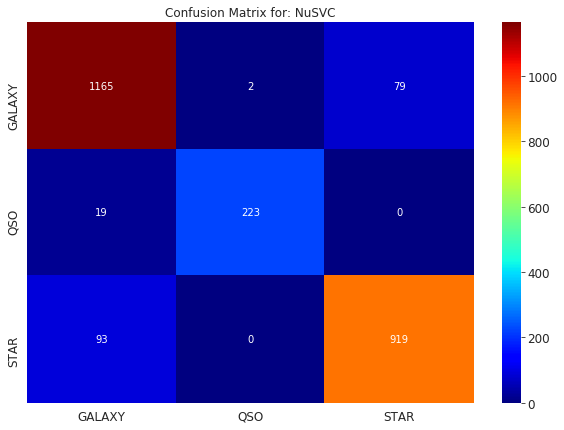

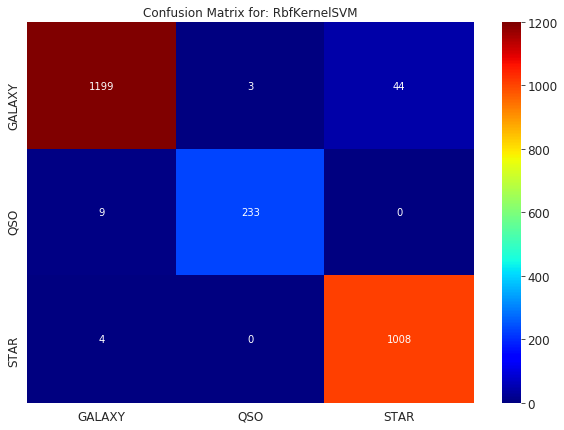

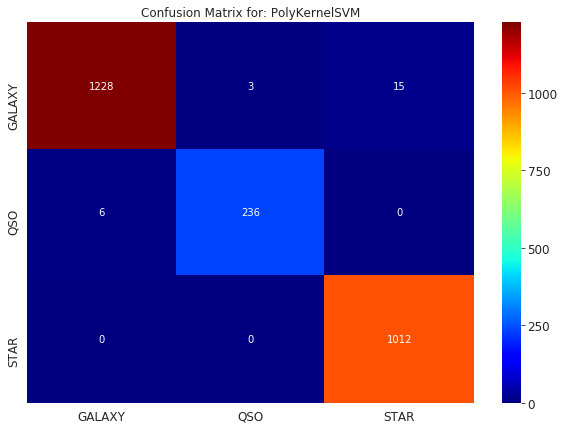

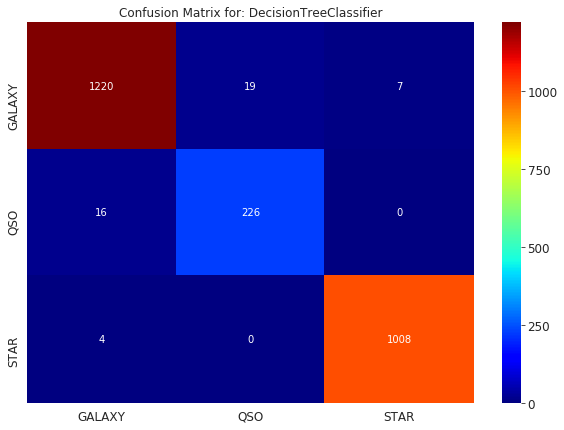

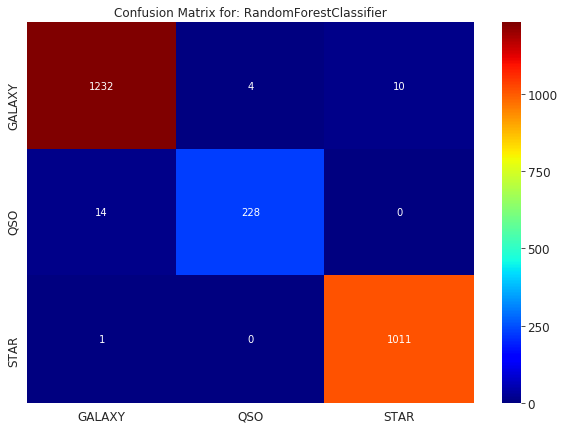

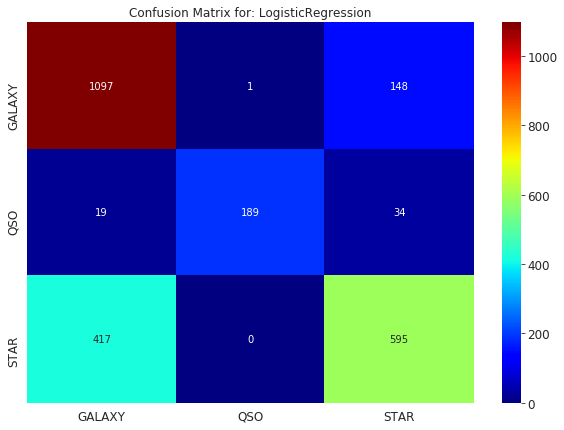

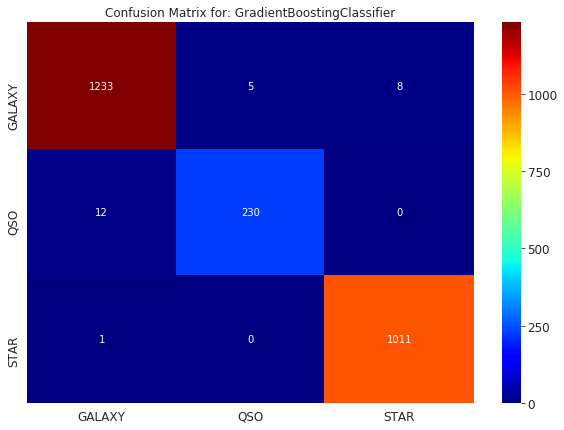

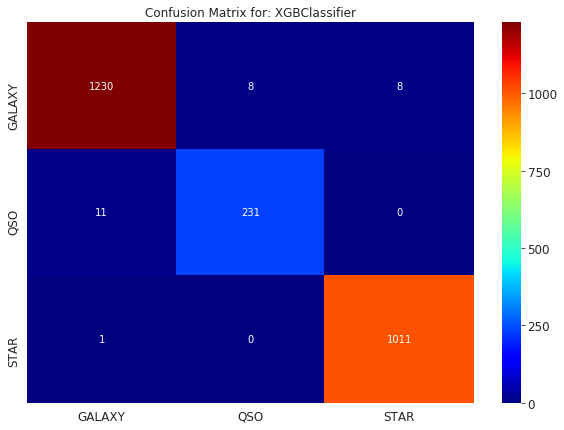

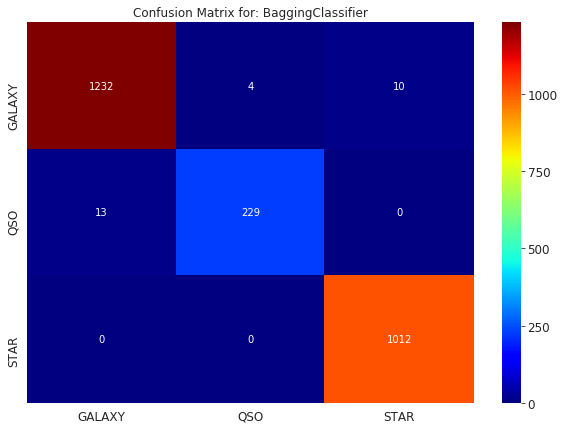

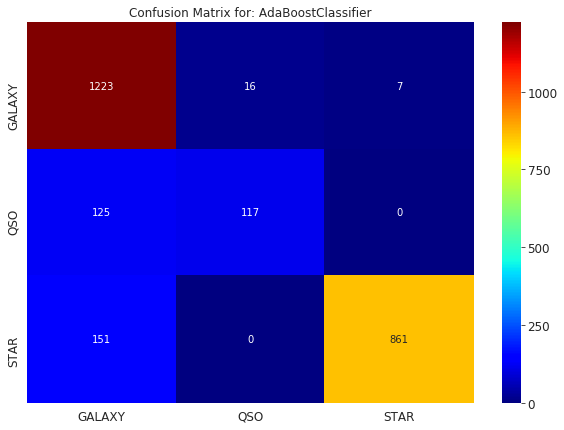

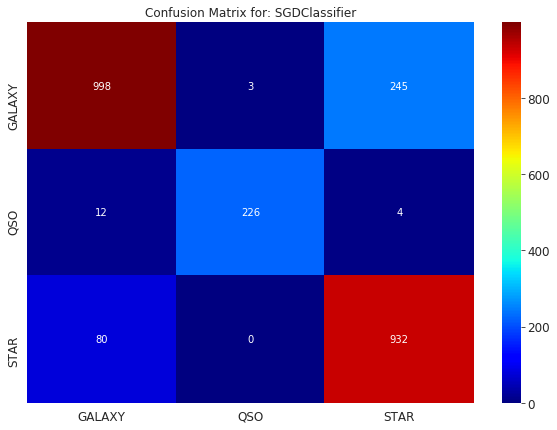

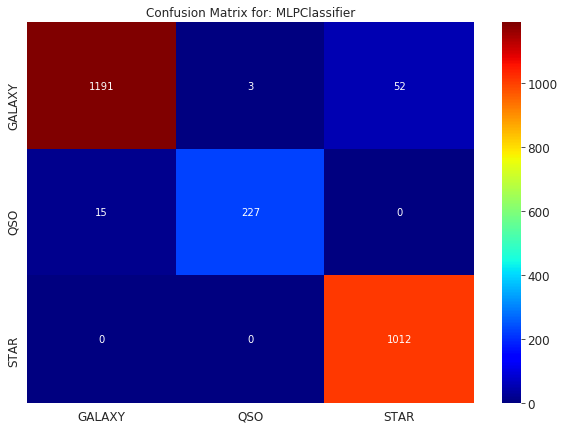

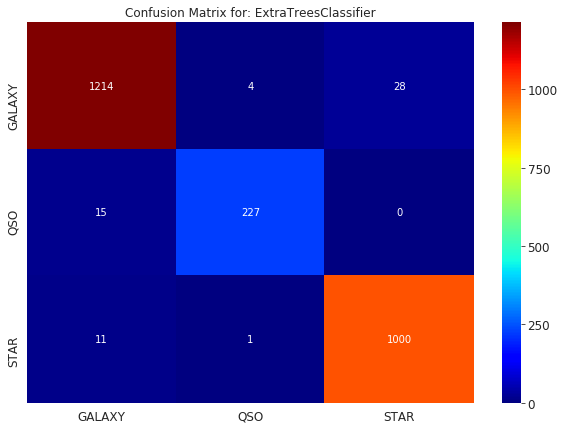

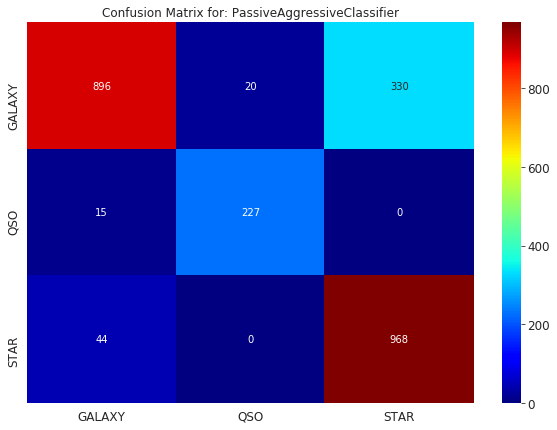

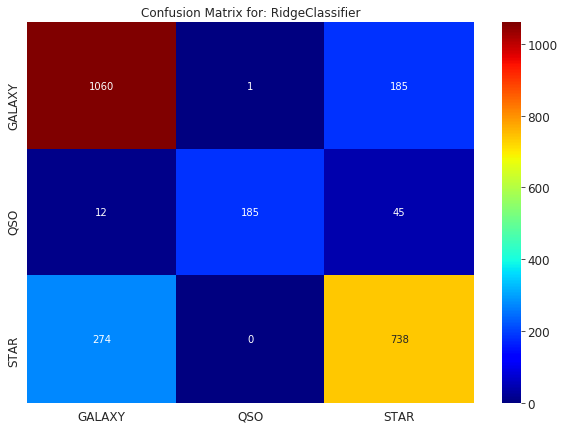

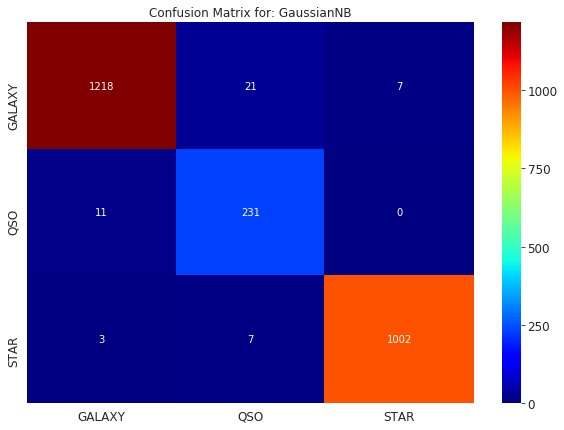

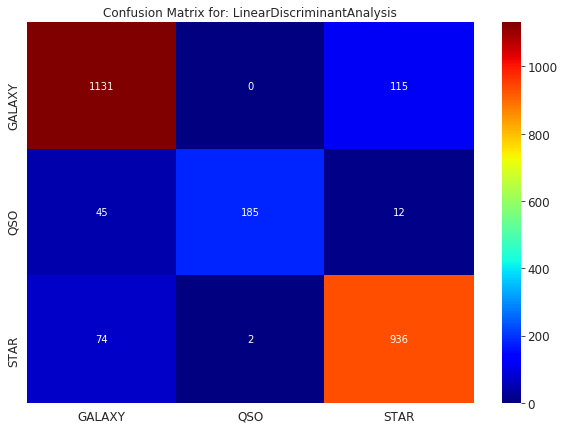

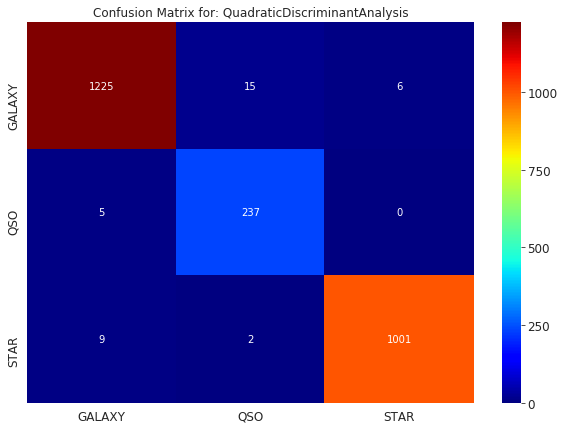

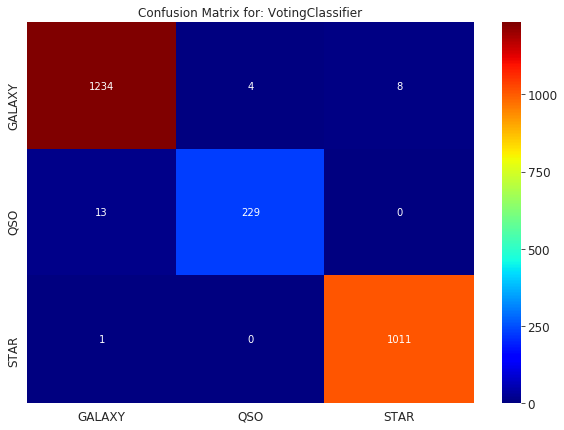

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)